# Optimal Execution Strategy incorporating Order Flow (Chap 7.3)

This file implements the optimal acquisition strategy when incorporating the order flow from the remainder of the market into the midprice. The theory is covered in Chapter 7.3 of

Algorithmic and High-Frequency Trading 
(c) Cartea, Jaimungal, & Penalva, 2015
Cambridge University Press

https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance/dp/1107091144/ref=cm_cr_arp_d_product_top?ie=UTF8

The trader aims to minimize the performance criterion
$$
\mathbb{E}\left[X_{T}^{\nu}+Q_{T}^{\nu}\left(S_{T}^{\nu}-\alpha Q_{T}^{\nu}\right)-\phi \int_{0}^{T}\left(Q_{u}^{\nu}\right)^{2} d u\right].
$$
Here, $Q_t$ denotes the trader's inventory, $X_t$ is their cash process, and $S_t$ is the asset price, and they satisfy the SDEs:
$$
Q_{t}^{\nu}=Q_{0}^{\nu} + \int_0^t - \nu_{t} d t
$$
$$
X_{t}^{\nu}=X_{0}^{\nu} + \int_0^t \left(S_{t}^{\nu}-k \nu_{t}\right) \nu_{t} d t 
$$
$$
S_t = S_0 + \int_0^t b \left(\mu_t - \nu_u\right)\,du + \sigma\,W_t
$$
where $W_t$ is a Brownian motion and $\mu_t=$ is the net order-flow from all other traders assumed to be a shot-noise process. Specifically, $\mu_t$ satisfies the SDE
$$
d \mu_{t} =-\kappa \mu_{t} \, dt+\eta_{1+L_{t^-}^+}\, d L_{t}^{+} - \eta_{1+L_{t^-}^-}\, d L_{t}^{-}
$$
where $L^\pm_t$ are independent Poisson processes with intensity $\lambda^\pm$, and $\eta_1^\pm,\eta_2^\pm,\dots$ are iid random variables representing the impact of order-flow changes.

In [1]:
# load packages
import time
import math
import numpy as np
import matplotlib.pyplot as plt
# with __import__('importnb').Notebook(): 
#     import OrderFlow_helpers
from scipy import interpolate
np.random.seed(30)
np.seterr(divide='ignore', invalid='ignore')
font = {'family': 'serif',
        'style': 'italic',
        # 'color': 'darkred',
        'weight': 1,
        'size': 16,
        }

Initialize a number of constants used in the analysis

In [2]:
Nsims = 5000  # Number of simulations

# Time grid
T = 1  # Expiry
Ndt = int(6.5*360)  # Number of time increments
dt = T/Ndt  # Time change increment
t = np.arange(0, T+0.00000001, dt)  # Time increments vector 

k = 0.001  # Temporary Market Impact
b = 0.0001  # Permanent Price Impact Factor

lam = 1000 # Frequency of Arrival of Order-Flow Changes
kappa = 10  # Rate of Order-Flow Mean-reversion
eta_mean = 5  # Mean Order-Flow Jump Size

initial_price = 50  # Starting Fundamental Price
initial_invt = 1  # Starting Inventory amount
phi = 0.01  # Running penalty coefficient
sigma = 0.1  # Volatilty (recall this is an artihmetic model)

alpha = 100  # Terminal penalty 
idxfig = [52, 291, 9]  # Index of path to be plotted

## Formulation of the optimal strategy
Next, we look at how the strategy performs along simulated paths and compare it with the Almgren-Chris strategy.

The Almgren-Chris strategy acquistion strategy is deterministic and given by the expression
$$
\nu^{AC}_t = \sqrt{k\phi}\,\frac{\xi\,e^{2\gamma(T-t)}+1}{\xi\,e^{2\gamma(T-t)}-1}, \qquad\text{where}\qquad \xi = \frac{\alpha+\sqrt{k\phi}}{\alpha-\sqrt{k\phi}}, \qquad\text{and}\qquad \gamma=\sqrt{\frac{\phi}{k}}
$$
see Equation (7.6).

As shown in the Chapter, the optimal trading rate subject to order-flow is given by
$$
\nu_{t}^{*}=-\frac{1}{k} \chi(t) Q_{t}^{\nu^{*}}-\frac{b}{2 k} \overline{\ell}_{1}(t) \mu_{t}
$$
where $\ell_{1}^{t}$ can be expressed as 
$$
\ell_{1}(t)=b \int_{t}^{T} e^{-\kappa(s-t)} e^{\frac{1}{k} \int_{t}^{s}\chi(u) d u}  d s
$$
and  simplifies to
$$
{\qquad \ell_{1}(t)=b \;\overline{\ell}_{1}(T-t) \geq 0} 
$$
where
$$
 {\qquad \overline{\ell}_{1}(\tau)=\frac{1}{\zeta e^{\gamma \tau}-e^{-\gamma \tau}}\left\{e^{\gamma \tau} \frac{1-e^{-(\kappa+\gamma) \tau}}{\kappa+\gamma} \zeta-e^{-\gamma \tau} \frac{1-e^{-(\kappa-\gamma) \tau}}{\kappa-\gamma}\right\}}
$$


In [18]:
# Computing chi variable
zeta = ((alpha-0.5*b) + (k*phi)**0.5)/((alpha-0.5*b) - (k*phi)**0.5)  
gamma = (phi/k)**0.5
tau = T-t  # Time remaining to the end of the trading horizon
chi = np.divide((k*phi)**0.5*(1 + zeta*np.exp(2*gamma*tau)), (1 - zeta*np.exp(2*gamma*tau)))

# Computing ell variable
def exp_p(a, tau):
    return (1 - np.exp(-a*tau)) / a
v1 = np.exp(gamma * tau)
tot = kappa + gamma
dif = kappa - gamma
ell = (zeta * v1 * exp_p(tot, tau)- v1**-1 * exp_p(dif, tau) )/(zeta * v1 - v1**-1)
# ell = 1/(zeta * v1 - v1**-1)


## Simulate the optimal strategy
We next generating simulated sample paths,  along those paths trade optimally, and compare with Almgren-Chriss. The simulation is conducted by
* compute the optimal trading rate given the current value of order-flow using 
* execute a trade
* account for its cost
* account for the impact of the trade on price
* simulate the next price (accountinf for trading impact of your trades and others)
* simulate the next order-flow

In [21]:
# Allocate space for the processes we simulate and store

mu = np.full([Nsims, Ndt+1], np.nan)  # Order Flow matrix

# Initializing variables for simulation base on computed strategy
X = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q = np.full([Nsims, Ndt+1], np.nan)  # Inventory matrix

S = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix

nu = np.full([Nsims, Ndt+1], np.nan)  # Rate of Trading matrix

# Initializing variables for simulation of Almgren-Chriss strategy
X_AC = np.full([Nsims, Ndt+1], np.nan)  # Cost matrix of Strategy
Q_AC = np.full([Ndt+1], np.nan)  # Inventory matrix

S_AC = np.full([Nsims, Ndt+1], np.nan)  # Execution Price matrix

nu_AC = np.full([Ndt+1], np.nan)  # Execution Price matrix

In [22]:
# Initial  conditions
Q[:, 0] = initial_invt
mu[:, 0] = 0
S[:, 0] = initial_price  
X[:, 0] = 0 

Q_AC[0] = initial_invt 
S_AC[:, 0] = initial_price
X_AC[:, 0] = 0

In [32]:
-1/k*chi[0]*Q[:, 0] - 0.5 * b / k * ell[0] * mu[:, 0]

array([3.17362938, 3.17362938, 3.17362938, ..., 3.17362938, 3.17362938,
       3.17362938])

In [9]:
#  Simulating computed strategy
for i in range(Ndt):

    # Compute optimal trading rate
    nu[:, i] = -1/k*chi[i]*Q[:, i] - 0.5 * b / k * ell[i] * mu[:, i]
    nu_AC[i] = -1/k*chi[i] * Q_AC[i]

    # Account for the cost of the trades above and update inventory
    X[:, i + 1] = X[:, i] + (S[:, i] - k * nu[:, i]) * nu[:, i] * dt
    Q[:, i+1] = Q[:, i] - nu[:, i] * dt
    
    # If you were trading using Almgren-Chriss this is what you would do
    X_AC[:, i + 1] = X_AC[:, i] + (S_AC[:, i] - k * nu_AC[i]) * nu_AC[i] * dt
    Q_AC[i+1] = Q_AC[i] - nu_AC[i] * dt

    # simulate the SDE for price forward 
    dW = dt**0.5 * np.random.randn(Nsims, 1)
    
    S[:, i + 1] = S[:, i] + b * (mu[:, i] - nu[:, i]) * dt + (sigma * dW).reshape(Nsims)
    S_AC[:, i + 1] = S_AC[:, i] + b * (mu[:, i] - nu_AC[i]) * dt + (sigma * dW).reshape(Nsims)
    
    #  simulate order-flow forward
    
    # decide if an order-flow update arrives
    dn = (np.random.rand(Nsims, 1) < 1 - np.exp(-2 * lam * dt)).astype(int)
    # decide if it adds to the buy/sell pressure
    buysell = (np.random.rand(Nsims, 1) < 0.5)
    # generate the size of the order-flow impact
    eta = -eta_mean * np.log(np.random.rand(Nsims, 1))
    
    # simulate the SDE for mu forward
    mu[:, i + 1] = mu[:, i]*np.exp(-kappa * dt) + (eta * dn * (2 * buysell - 1)).reshape(Nsims)


In [10]:
# Visualizing variables as time procresses 
OrderFlow_helpers.PlotPath(t, T, S, idxfig, sigma, [initial_price - 2*sigma, initial_price + 2 * sigma], 'MidPrice ' + r'$(S_t)$')
OrderFlow_helpers.PlotPath(t, T, Q, idxfig, sigma, [-2*sigma, initial_invt],'Inventory ' + r'$Q_t^{\nu^\dagger}$')
OrderFlow_helpers.PlotPath(t, T, nu, idxfig, sigma, [0, 3.5], 'Trading Speed ' + r'$\nu_t^\dagger$')
OrderFlow_helpers.PlotPath(t, T, mu, idxfig, sigma, [-300, 300], 'OrderFlow ' + r'$\mu_t)$')


NameError: name 'OrderFlow_helpers' is not defined

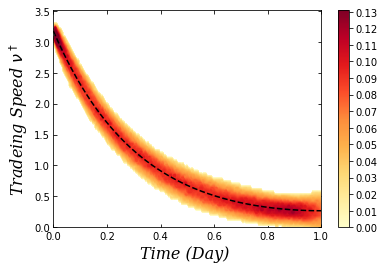

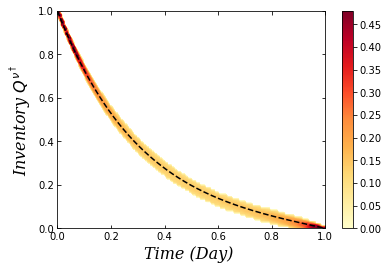

In [35]:
# Visualizing density plot of simulations
OrderFlow_helpers.PlotHeatMap(t, nu, nu_AC, 'Tradeing Speed ' + r'$\nu^\dagger$', n=40)
OrderFlow_helpers.PlotHeatMap(t, Q, Q_AC, 'Inventory ' + r'$Q^{\nu^\dagger}$', n=40, lower_threshold=0.05, upper_threshold=0.4)


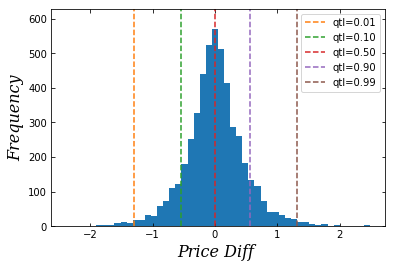

In [36]:
# Visualizing price difference between strategies 
fig_7 = plt.figure()
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
BasisPointSavings = ( X[:,-1]-X_AC[:, -1] ) / X_AC[:, -1] * 10**4

rets = plt.hist(BasisPointSavings, bins=50)

prob = [0.01, 0.1, 0.5, 0.9, 0.99]
q = np.quantile(BasisPointSavings, prob)
maxHeight = 1.1*np.max(rets[0])
for i in range(len(q)):
    plt.plot(q[i]*np.array([1,1]), np.array([0,maxHeight]), '--', label= prob[i])
plt.ylim((0,maxHeight))  
plt.ylabel('Frequency', fontdict=font)
plt.xlabel('Price Diff ', fontdict=font)
plt.legend(('qtl=0.01','qtl=0.10','qtl=0.50','qtl=0.90','qtl=0.99'))
plt.show()